INITIAL EDA 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
import re
from bs4 import BeautifulSoup

In [4]:
%pip install xgboost
# Auto-detect GPU availability and set XGBoost params
import shutil, subprocess
def detect_gpu():
    # prefer nvidia-smi if available
    if shutil.which('nvidia-smi') is not None:
        return True
    try:
        import torch
        return torch.cuda.is_available()
    except Exception:
        return False

USE_GPU = detect_gpu()
print('GPU available:', USE_GPU)
xgb_gpu_params = {'tree_method':'gpu_hist', 'predictor':'gpu_predictor'} if USE_GPU else {}


Note: you may need to restart the kernel to use updated packages.
GPU available: True



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
df = pd.read_csv('train.csv')

In [6]:

df = df.sample(50000,random_state=2)

In [7]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [8]:
df.shape

(50000, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 398782 to 226665
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            50000 non-null  int64 
 1   qid1          50000 non-null  int64 
 2   qid2          50000 non-null  int64 
 3   question1     50000 non-null  object
 4   question2     50000 non-null  object
 5   is_duplicate  50000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.7+ MB


In [10]:
df.describe()

,id,qid1,qid2,is_duplicate
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,202039.620540,216558.348160,221109.286460,0.367980
std,116676.467726,157406.264661,159619.862628,0.482261
min,3.000000,3.000000,8.000000,0.000000
25%,101217.000000,74339.000000,75780.250000,0.000000
50%,201649.500000,191585.000000,197742.500000,0.000000
75%,303025.000000,344729.750000,353753.250000,1.000000
max,404282.000000,537920.000000,537921.000000,1.000000


In [11]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [12]:
df = df.dropna()


In [13]:
df.duplicated().sum()

0

In [14]:
print(df['is_duplicate'].value_counts())


is_duplicate
0    31601
1    18399
Name: count, dtype: int64


    HANDLING IMBALANCE

In [15]:
df_0 = df[df['is_duplicate'] == 0]
df_1 = df[df['is_duplicate'] == 1]


In [16]:
df_0_sampled = df_0.sample(
    n=len(df_1),
    random_state=42
)


In [17]:
df_balanced = pd.concat([df_0_sampled, df_1])


In [18]:
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [19]:
df['is_duplicate'].value_counts()


is_duplicate
0    18399
1    18399
Name: count, dtype: int64

In [20]:
df.shape

(36798, 6)

In [21]:
# repeated questions from q1 and q2 combined 


qid = pd.Series(df['qid1'].tolist()+ df['qid2'].tolist())
print("Number of unique questions", np.unique(qid).shape[0])
x = qid.value_counts() > 1
print('Number of questions getting repeated ',x[x].shape[0])

Number of unique questions 64651
Number of questions getting repeated  5785


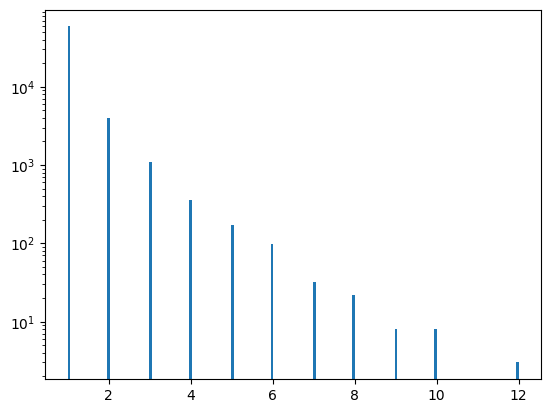

In [22]:
# histogram for repeated questions 

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

        PREPROCESSING QUESTIONS 

In [23]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [24]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

    FEATURE ENGINEERING 

In [25]:
# 1) char length of q1
# 2) char length of q2
# 3) No. of words in q1
# 4) No. of words in q2
# 5) No. of common unique words
# 6) Total No. of words from both 
# 7) word common / word total 

In [26]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

In [27]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
0,22724,42623,42624,what can i do with an mba in management inform...,how do people earn through amway,0,59,32
1,65221,35102,42464,what is the best effective treatment for impot...,how do i overcome impotence,1,50,27
2,63701,110808,110809,is it possible that i have changed from extrov...,i have seen some introverts change to being ex...,0,81,88
3,78044,133145,133146,which are the best colleges for electronics an...,which are the best colleges for electronics an...,0,83,101
4,367123,497380,497381,can i tell how i feel for her and i love her i...,dslr vs handycam which is best for the youtube...,0,75,80


In [28]:
df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
0,22724,42623,42624,what can i do with an mba in management inform...,how do people earn through amway,0,59,32,11,6
1,65221,35102,42464,what is the best effective treatment for impot...,how do i overcome impotence,1,50,27,8,5
2,63701,110808,110809,is it possible that i have changed from extrov...,i have seen some introverts change to being ex...,0,81,88,14,14
3,78044,133145,133146,which are the best colleges for electronics an...,which are the best colleges for electronics an...,0,83,101,12,16
4,367123,497380,497381,can i tell how i feel for her and i love her i...,dslr vs handycam which is best for the youtube...,0,75,80,16,17


In [29]:
def common_words(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)


In [30]:
df['word_common'] = df.apply(common_words,axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
0,22724,42623,42624,what can i do with an mba in management inform...,how do people earn through amway,0,59,32,11,6,1
1,65221,35102,42464,what is the best effective treatment for impot...,how do i overcome impotence,1,50,27,8,5,1
2,63701,110808,110809,is it possible that i have changed from extrov...,i have seen some introverts change to being ex...,0,81,88,14,14,3
3,78044,133145,133146,which are the best colleges for electronics an...,which are the best colleges for electronics an...,0,83,101,12,16,11
4,367123,497380,497381,can i tell how i feel for her and i love her i...,dslr vs handycam which is best for the youtube...,0,75,80,16,17,2


In [31]:
def total_words(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" ")))
    return (len(w1)+len(w2))

In [32]:
df['word_total'] = df.apply(total_words,axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
0,22724,42623,42624,what can i do with an mba in management inform...,how do people earn through amway,0,59,32,11,6,1,17
1,65221,35102,42464,what is the best effective treatment for impot...,how do i overcome impotence,1,50,27,8,5,1,13
2,63701,110808,110809,is it possible that i have changed from extrov...,i have seen some introverts change to being ex...,0,81,88,14,14,3,26
3,78044,133145,133146,which are the best colleges for electronics an...,which are the best colleges for electronics an...,0,83,101,12,16,11,28
4,367123,497380,497381,can i tell how i feel for her and i love her i...,dslr vs handycam which is best for the youtube...,0,75,80,16,17,2,28


In [33]:
df['word_share']=round(df['word_common']/df['word_total'],2)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
0,22724,42623,42624,what can i do with an mba in management inform...,how do people earn through amway,0,59,32,11,6,1,17,0.06
1,65221,35102,42464,what is the best effective treatment for impot...,how do i overcome impotence,1,50,27,8,5,1,13,0.08
2,63701,110808,110809,is it possible that i have changed from extrov...,i have seen some introverts change to being ex...,0,81,88,14,14,3,26,0.12
3,78044,133145,133146,which are the best colleges for electronics an...,which are the best colleges for electronics an...,0,83,101,12,16,11,28,0.39
4,367123,497380,497381,can i tell how i feel for her and i love her i...,dslr vs handycam which is best for the youtube...,0,75,80,16,17,2,28,0.07


In [34]:
df.shape

(36798, 13)

    EDA ON FEATURES 

minimum characters :  1
maximum characters :  397
Average num of characters 57


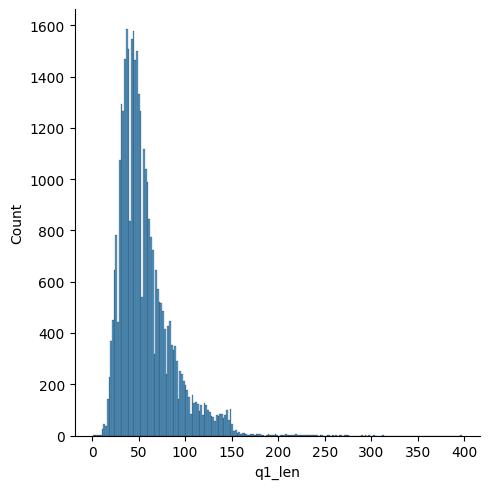

In [35]:
sns.displot(df['q1_len'])
print('minimum characters : ',df['q1_len'].min())
print('maximum characters : ',df['q1_len'].max())
print('Average num of characters',int(df['q1_len'].mean()))

minimum characters :  0
maximum characters :  1162
Average num of characters 57


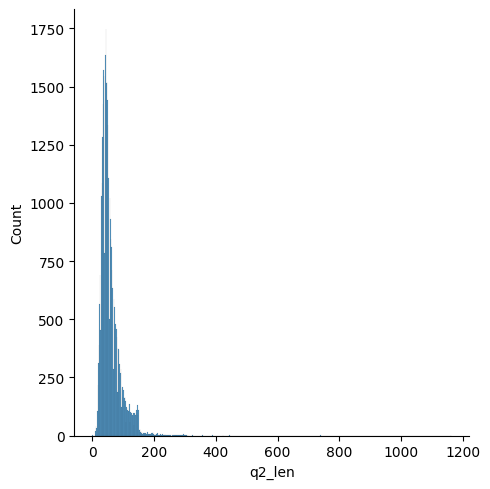

In [36]:
sns.displot(df['q2_len'])
print('minimum characters : ',df['q2_len'].min())
print('maximum characters : ',df['q2_len'].max())
print('Average num of characters',int(df['q2_len'].mean()))

minimum words :  1
maximum words :  79
Average num of words 11


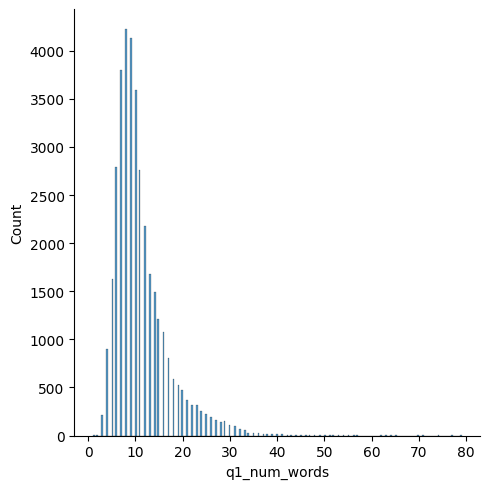

In [37]:
sns.displot(df['q1_num_words'])
print('minimum words : ',df['q1_num_words'].min())
print('maximum words : ',df['q1_num_words'].max())
print('Average num of words',int(df['q1_num_words'].mean()))

minimum words :  1
maximum words :  270
Average num of words 11


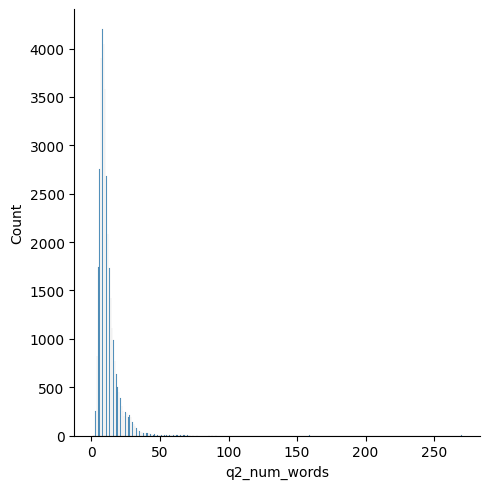

In [38]:
sns.displot(df['q2_num_words'])
print('minimum words : ',df['q2_num_words'].min())
print('maximum words : ',df['q2_num_words'].max())
print('Average num of words',int(df['q2_num_words'].mean()))

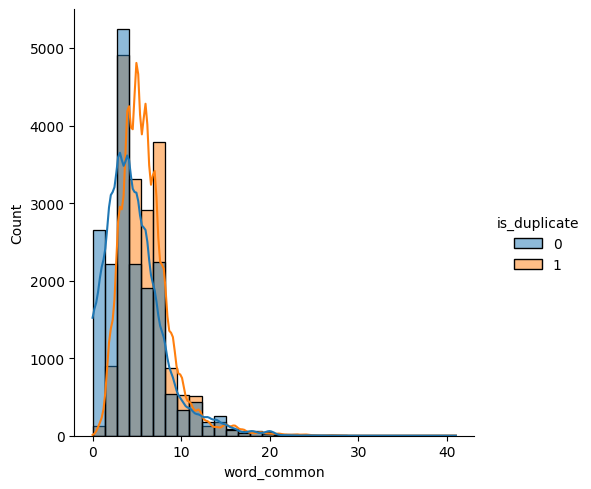

In [39]:
# common words 

sns.displot(
    data=df,
    x='word_common',
    hue='is_duplicate',
    kde=True,
    bins=30
)
plt.show()


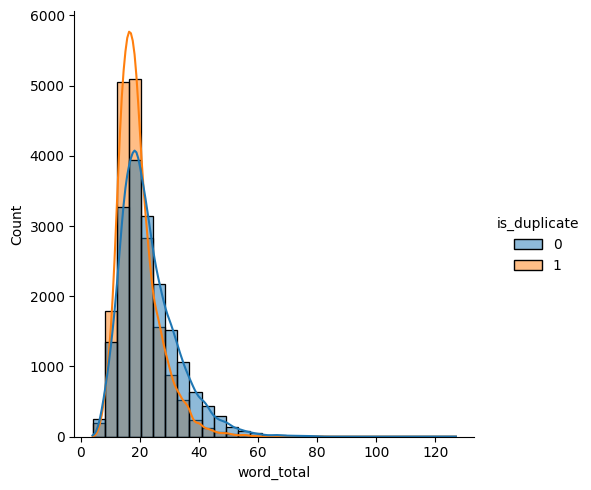

In [40]:
# total words 

sns.displot(
    data=df,
    x='word_total',
    hue='is_duplicate',
    kde=True,
    bins=30
)
plt.show()

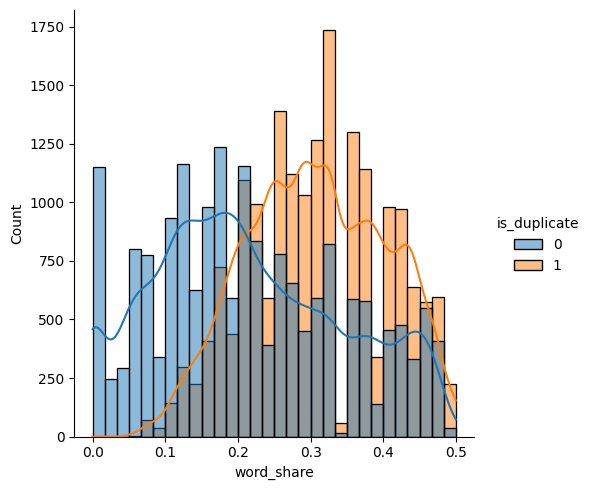

In [41]:
#  word share 

sns.displot(
    data=df,
    x='word_share',
    hue='is_duplicate',
    kde=True,
    bins=30
)
plt.show()

    ADVANCED FEATURE ENGINNERING

In [42]:
!pip install nltk


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [44]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CSE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [46]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
0,22724,42623,42624,what can i do with an mba in management inform...,how do people earn through amway,0,59,32,11,6,...,17,0.06,0.000000,0.000000,0.333322,0.142855,0.166664,0.090908,0.0,0.0
1,65221,35102,42464,what is the best effective treatment for impot...,how do i overcome impotence,1,50,27,8,5,...,13,0.08,0.499975,0.249994,0.000000,0.000000,0.199996,0.124998,1.0,0.0
2,63701,110808,110809,is it possible that i have changed from extrov...,i have seen some introverts change to being ex...,0,81,88,14,14,...,26,0.12,0.000000,0.000000,0.499992,0.333330,0.230767,0.214284,0.0,0.0
3,78044,133145,133146,which are the best colleges for electronics an...,which are the best colleges for electronics an...,0,83,101,12,16,...,28,0.39,0.999983,0.749991,0.833319,0.624992,0.916659,0.687496,1.0,1.0
4,367123,497380,497381,can i tell how i feel for her and i love her i...,dslr vs handycam which is best for the youtube...,0,75,80,16,17,...,28,0.07,0.000000,0.000000,0.333328,0.285710,0.133332,0.124999,0.0,0.0


In [47]:
!pip install distance fuzzywuzzy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    if len(strs) > 0:
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    else:
        length_features[2] = 0.0
    
    return length_features

In [49]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [50]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
0,22724,42623,42624,what can i do with an mba in management inform...,how do people earn through amway,0,59,32,11,6,...,0.000000,0.333322,0.142855,0.166664,0.090908,0.0,0.0,5.0,8.5,0.121212
1,65221,35102,42464,what is the best effective treatment for impot...,how do i overcome impotence,1,50,27,8,5,...,0.249994,0.000000,0.000000,0.199996,0.124998,1.0,0.0,3.0,6.5,0.357143
2,63701,110808,110809,is it possible that i have changed from extrov...,i have seen some introverts change to being ex...,0,81,88,14,14,...,0.000000,0.499992,0.333330,0.230767,0.214284,0.0,0.0,1.0,13.5,0.121951
3,78044,133145,133146,which are the best colleges for electronics an...,which are the best colleges for electronics an...,0,83,101,12,16,...,0.749991,0.833319,0.624992,0.916659,0.687496,1.0,1.0,4.0,14.0,0.892857
4,367123,497380,497381,can i tell how i feel for her and i love her i...,dslr vs handycam which is best for the youtube...,0,75,80,16,17,...,0.000000,0.333328,0.285710,0.133332,0.124999,0.0,0.0,1.0,15.5,0.065789


In [51]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

c:\Users\Krisha\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [52]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [53]:
print(df.shape)
df.head()

(36798, 28)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,22724,42623,42624,what can i do with an mba in management inform...,how do people earn through amway,0,59,32,11,6,...,0.090908,0.0,0.0,5.0,8.5,0.121212,26,34,29,22
1,65221,35102,42464,what is the best effective treatment for impot...,how do i overcome impotence,1,50,27,8,5,...,0.124998,1.0,0.0,3.0,6.5,0.357143,49,59,44,50
2,63701,110808,110809,is it possible that i have changed from extrov...,i have seen some introverts change to being ex...,0,81,88,14,14,...,0.214284,0.0,0.0,1.0,13.5,0.121951,45,50,56,56
3,78044,133145,133146,which are the best colleges for electronics an...,which are the best colleges for electronics an...,0,83,101,12,16,...,0.687496,1.0,1.0,4.0,14.0,0.892857,90,93,89,98
4,367123,497380,497381,can i tell how i feel for her and i love her i...,dslr vs handycam which is best for the youtube...,0,75,80,16,17,...,0.124999,0.0,0.0,1.0,15.5,0.065789,28,31,29,30


In [54]:
# sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

In [55]:
# sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

In [56]:
# sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

In [57]:
# sns.pairplot(df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

In [58]:
# sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [59]:
# # Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

# from sklearn.preprocessing import MinMaxScaler

# X = MinMaxScaler().fit_transform(df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
# y = df['is_duplicate'].values

In [60]:
# from sklearn.manifold import TSNE

# tsne2d = TSNE(
#     n_components=2,
#     init='random', # pca
#     random_state=101,
#     method='barnes_hut',
#     max_iter=1000,
#     verbose=2,
#     angle=0.5
# ).fit_transform(X)

In [61]:
# x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# # draw the plot in appropriate place in the grid
# sns.lmplot(
#     data=x_df,
#     x='x',
#     y='y',
#     hue='label',
#     fit_reg=False,
#     height=8,
#     palette="Set1",
#     markers=['s','o']
# )


In [62]:
# tsne3d = TSNE(
#     n_components=3,
#     init='random', # pca
#     random_state=101,
#     method='barnes_hut',
#     max_iter=1000,
#     verbose=2,
#     angle=0.5
# ).fit_transform(X)

In [63]:
# import plotly.graph_objs as go
# import plotly.tools as tls
# import plotly.offline as py
# py.init_notebook_mode(connected=True)

# trace1 = go.Scatter3d(
#     x=tsne3d[:,0],
#     y=tsne3d[:,1],
#     z=tsne3d[:,2],
#     mode='markers',
#     marker=dict(
#         sizemode='diameter',
#         color = y,
#         colorscale = 'Portland',
#         colorbar = dict(title = 'duplicate'),
#         line=dict(color='rgb(255, 255, 255)'),
#         opacity=0.75
#     )
# )

# data=[trace1]
# layout=dict(height=800, width=800, title='3d embedding with engineered features')
# fig=dict(data=data, layout=layout)
# py.iplot(fig, filename='3DBubble')

    FINAL DATAFRAME

In [64]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
0,what can i do with an mba in management inform...,how do people earn through amway
1,what is the best effective treatment for impot...,how do i overcome impotence
2,is it possible that i have changed from extrov...,i have seen some introverts change to being ex...
3,which are the best colleges for electronics an...,which are the best colleges for electronics an...
4,can i tell how i feel for her and i love her i...,dslr vs handycam which is best for the youtube...


In [65]:
final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()
for_wtv_df = final_df

(36798, 23)


    VECTORIZATION AND MODEL

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
# keep as sparse matrix to avoid densifying (large memory use)
q_mat = cv.fit_transform(questions)
q1_mat = q_mat[:len(ques_df)]
q2_mat = q_mat[len(ques_df):]

In [67]:
# create sparse DataFrames from the sparse matrices (memory efficient)
temp_df1 = pd.DataFrame.sparse.from_spmatrix(q1_mat, index=ques_df.index)
temp_df2 = pd.DataFrame.sparse.from_spmatrix(q2_mat, index=ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(36798, 6000)

In [68]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(36798, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0,59,32,11,6,1,17,0.06,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,50,27,8,5,1,13,0.08,0.499975,0.249994,...,0,0,0,0,0,0,0,0,0,0
2,0,81,88,14,14,3,26,0.12,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0,83,101,12,16,11,28,0.39,0.999983,0.749991,...,0,0,1,0,0,0,0,0,0,0
4,0,75,80,16,17,2,28,0.07,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0


In [69]:

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7936141304347826

In [71]:
from xgboost import XGBClassifier
xgb = XGBClassifier(**xgb_gpu_params)
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

XGBoostError: Invalid Input: 'gpu_hist', valid values are: {'approx', 'auto', 'exact', 'hist'}

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[2550, 1067],
       [ 452, 3291]], dtype=int64)

In [ ]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[2611, 1006],
       [ 483, 3260]], dtype=int64)

## Hyperparameter Tuning - BOW

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')


lr_param_dist = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],          # l2 almost always better for text
    'solver': ['liblinear'],    # stable & fast
    'class_weight': [None, 'balanced']
}

rf_param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}
xgb_param_dist = {
    'n_estimators': [200, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1]
}


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF Parameters (BOW): {'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Best RF Score (BOW): 0.7800815693835016

In [ ]:
# Random Forest Tuning - BOW
rf_bow = RandomForestClassifier(random_state=42)

rf_random_bow = RandomizedSearchCV(
    estimator=rf_bow,
    param_distributions=rf_param_dist,
    n_iter=30,  # Reduced iterations to save memory
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2,  # Reduced from -1 to prevent memory issues
    scoring='f1'
)

rf_random_bow.fit(X_train, y_train)

print("Best RF Parameters (BOW):", rf_random_bow.best_params_)
print("Best RF Score (BOW):", rf_random_bow.best_score_)

In [ ]:
# XGBoost Tuning - BOW
xgb_bow = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **xgb_gpu_params)

xgb_random_bow = RandomizedSearchCV(
    estimator=xgb_bow,
    param_distributions=xgb_param_dist,
    n_iter=30,  # Reduced iterations to save memory
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2,  # Reduced from -1 to prevent memory issues
    scoring='f1'
)

xgb_random_bow.fit(X_train, y_train)

print("Best XGB Parameters (BOW):", xgb_random_bow.best_params_)
print("Best XGB Score (BOW):", xgb_random_bow.best_score_)

In [ ]:
# Logistic Regression Tuning - BOW
lr_bow = LogisticRegression(random_state=42)

lr_random_bow = RandomizedSearchCV(
    estimator=lr_bow,
    param_distributions=lr_param_dist,
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2,
    scoring='f1'
)

lr_random_bow.fit(X_train, y_train)

print("Best LR Parameters (BOW):", lr_random_bow.best_params_)
print("Best LR Score (BOW):", lr_random_bow.best_score_)

In [ ]:
# Evaluate Best Models - BOW
y_pred_rf_tuned_bow = rf_random_bow.best_estimator_.predict(X_test)
y_pred_xgb_tuned_bow = xgb_random_bow.best_estimator_.predict(X_test)
y_pred_lr_tuned_bow = lr_random_bow.best_estimator_.predict(X_test)

print("=" * 50)
print("TUNED RANDOM FOREST - BOW")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_tuned_bow):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf_tuned_bow):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_rf_tuned_bow):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_tuned_bow))

print("\n" + "=" * 50)
print("TUNED XGBOOST - BOW")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_tuned_bow):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb_tuned_bow):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_xgb_tuned_bow):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_tuned_bow))

print("\n" + "=" * 50)
print("TUNED LOGISTIC REGRESSION - BOW")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_tuned_bow):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr_tuned_bow):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_lr_tuned_bow):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_tuned_bow))

In [ ]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [ ]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [ ]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [ ]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [ ]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1 (keep sparse until final combine)
    from scipy import sparse
    q1_bow = cv.transform([q1])
    
    # bow feature for q2
    q2_bow = cv.transform([q2])
    
    # combine dense small features with sparse bow features efficiently
    input_arr = np.array(input_query).reshape(1, -1)
    input_sparse = sparse.csr_matrix(input_arr)
    combined = sparse.hstack([input_sparse, q1_bow, q2_bow])
    # return as dense array (single-row), use .A to avoid .toarray() string
    return combined.A

In [ ]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [ ]:
rf.predict(query_point_creator(q1,q2))

In [ ]:
xgb.predict(query_point_creator(q1,q3))

In [ ]:
cv

VECTORIZATION AND MODEL PART 2 (WORD TO VEC)

In [ ]:
!pip install gensim

   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/24.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/24.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/24.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/24.4 MB ? eta -:--:--
    --------------------------------------- 0.5/24.4 MB 356.7 kB/s eta 0:01:07
    --------------------------------------- 0.5/24.4 MB 356.7 kB/s eta 0:01:07
    --------------------------------------- 0.5/24.4 MB 356.7 kB/s eta 0:01:07
    --------------------------------------- 0.5/24.4 MB 356.7 kB/s eta 0:01:07
   - -------------------------------------- 0.8/24.4 MB 322.6 kB/s eta 0:01:14
   - -------------------------------------- 0.8/24.4 MB 322.6 kB/s eta 0:01:14
   - -------------------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import gensim.downloader as api

w2v = api.load("word2vec-google-news-300")


In [ ]:
import re

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z ]', '', text)
    return text.split()


In [ ]:
import numpy as np

def sentence_vector(sentence, model, vector_size=300):
    words = preprocess(sentence)
    vectors = [model[word] for word in words if word in model]

    if len(vectors) == 0:
        return np.zeros(vector_size)

    return np.mean(vectors, axis=0)


In [ ]:
q1_vectors = np.vstack(
    ques_df['question1'].apply(lambda x: sentence_vector(x, w2v))
)

q2_vectors = np.vstack(
    ques_df['question2'].apply(lambda x: sentence_vector(x, w2v))
)


In [ ]:
q1_df = pd.DataFrame(q1_vectors, index=ques_df.index)
q2_df = pd.DataFrame(q2_vectors, index=ques_df.index)

final_df_wtv = pd.concat([for_wtv_df, q1_df, q2_df], axis=1)


In [ ]:
final_df_wtv.head()

In [ ]:
final_df_wtv.shape

In [ ]:

from sklearn.model_selection import train_test_split
X_train_wtv,X_test_wtv,y_train_wtv,y_test_wtv = train_test_split(final_df_wtv.iloc[:,1:].values,final_df_wtv.iloc[:,0].values,test_size=0.2,random_state=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train_wtv,y_train_wtv)
y_pred_wtv = rf.predict(X_test_wtv)
accuracy_score(y_test_wtv,y_pred_wtv)

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(**xgb_gpu_params)
xgb.fit(X_train_wtv,y_train_wtv)
y_pred_wtv_1 = xgb.predict(X_test_wtv)
accuracy_score(y_test_wtv,y_pred_wtv_1)

In [ ]:
# for random forest model
confusion_matrix(y_test_wtv,y_pred_wtv)

In [ ]:
# for xgboost model
confusion_matrix(y_test_wtv,y_pred_wtv_1)

## Hyperparameter Tuning - Word2Vec

In [ ]:
# Random Forest Tuning - Word2Vec
rf_wtv = RandomForestClassifier(random_state=42)

rf_random_wtv = RandomizedSearchCV(
    estimator=rf_wtv,
    param_distributions=rf_param_dist,
    n_iter=30,  # Reduced iterations to save memory
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2,  # Reduced from -1 to prevent memory issues
    scoring='f1'
)

rf_random_wtv.fit(X_train_wtv, y_train_wtv)

print("Best RF Parameters (Word2Vec):", rf_random_wtv.best_params_)
print("Best RF Score (Word2Vec):", rf_random_wtv.best_score_)

In [ ]:
# XGBoost Tuning - Word2Vec
xgb_wtv = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **xgb_gpu_params)

xgb_random_wtv = RandomizedSearchCV(
    estimator=xgb_wtv,
    param_distributions=xgb_param_dist,
    n_iter=30,  # Reduced iterations to save memory
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2,  # Reduced from -1 to prevent memory issues
    scoring='f1'
)

xgb_random_wtv.fit(X_train_wtv, y_train_wtv)

print("Best XGB Parameters (Word2Vec):", xgb_random_wtv.best_params_)
print("Best XGB Score (Word2Vec):", xgb_random_wtv.best_score_)

In [ ]:
# Logistic Regression Tuning - Word2Vec
lr_wtv = LogisticRegression(random_state=42)

lr_random_wtv = RandomizedSearchCV(
    estimator=lr_wtv,
    param_distributions=lr_param_dist,
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2,
    scoring='f1'
)

lr_random_wtv.fit(X_train_wtv, y_train_wtv)

print("Best LR Parameters (Word2Vec):", lr_random_wtv.best_params_)
print("Best LR Score (Word2Vec):", lr_random_wtv.best_score_)

In [ ]:
# Evaluate Best Models - Word2Vec
y_pred_rf_tuned_wtv = rf_random_wtv.best_estimator_.predict(X_test_wtv)
y_pred_xgb_tuned_wtv = xgb_random_wtv.best_estimator_.predict(X_test_wtv)
y_pred_lr_tuned_wtv = lr_random_wtv.best_estimator_.predict(X_test_wtv)

print("=" * 50)
print("TUNED RANDOM FOREST - Word2Vec")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test_wtv, y_pred_rf_tuned_wtv):.4f}")
print(f"F1 Score: {f1_score(y_test_wtv, y_pred_rf_tuned_wtv):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_wtv, y_pred_rf_tuned_wtv):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_wtv, y_pred_rf_tuned_wtv))

print("\n" + "=" * 50)
print("TUNED XGBOOST - Word2Vec")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test_wtv, y_pred_xgb_tuned_wtv):.4f}")
print(f"F1 Score: {f1_score(y_test_wtv, y_pred_xgb_tuned_wtv):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_wtv, y_pred_xgb_tuned_wtv):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_wtv, y_pred_xgb_tuned_wtv))

print("\n" + "=" * 50)
print("TUNED LOGISTIC REGRESSION - Word2Vec")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test_wtv, y_pred_lr_tuned_wtv):.4f}")
print(f"F1 Score: {f1_score(y_test_wtv, y_pred_lr_tuned_wtv):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_wtv, y_pred_lr_tuned_wtv):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_wtv, y_pred_lr_tuned_wtv))

Both BAG and Word to vc 

In [ ]:
q1_df = pd.DataFrame(q1_vectors, index=ques_df.index)
q2_df = pd.DataFrame(q2_vectors, index=ques_df.index)

final_df_wtv_bow = pd.concat([final_df, q1_df, q2_df], axis=1)

In [ ]:
final_df_wtv_bow.shape

In [ ]:
final_df_wtv_bow.head()

In [ ]:

from sklearn.model_selection import train_test_split
X_train_wtv_bow,X_test_wtv_bow,y_train_wtv_bow,y_test_wtv_bow = train_test_split(final_df_wtv_bow.iloc[:,1:].values,final_df_wtv_bow.iloc[:,0].values,test_size=0.2,random_state=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train_wtv_bow,y_train_wtv_bow)
y_pred_wtv_bow = rf.predict(X_test_wtv_bow)
accuracy_score(y_test_wtv_bow,y_pred_wtv_bow)

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(**xgb_gpu_params)
xgb.fit(X_train_wtv_bow,y_train_wtv_bow)
y_pred_wtv_bow_1 = xgb.predict(X_test_wtv_bow)
accuracy_score(y_test_wtv_bow,y_pred_wtv_bow_1)

In [ ]:
# for random forest model
confusion_matrix(y_test_wtv_bow,y_pred_wtv_bow)

In [ ]:
# for xgboost model
confusion_matrix(y_test_wtv_bow,y_pred_wtv_bow_1)

## Hyperparameter Tuning - BOW + Word2Vec

In [ ]:
# Random Forest Tuning - BOW + Word2Vec
rf_wtv_bow = RandomForestClassifier(random_state=42)

rf_random_wtv_bow = RandomizedSearchCV(
    estimator=rf_wtv_bow,
    param_distributions=rf_param_dist,
    n_iter=30,  # Reduced iterations to save memory
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2,  # Reduced from -1 to prevent memory issues
    scoring='f1'
)

rf_random_wtv_bow.fit(X_train_wtv_bow, y_train_wtv_bow)

print("Best RF Parameters (BOW+Word2Vec):", rf_random_wtv_bow.best_params_)
print("Best RF Score (BOW+Word2Vec):", rf_random_wtv_bow.best_score_)

In [ ]:
# XGBoost Tuning - BOW + Word2Vec
xgb_wtv_bow = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **xgb_gpu_params)

xgb_random_wtv_bow = RandomizedSearchCV(
    estimator=xgb_wtv_bow,
    param_distributions=xgb_param_dist,
    n_iter=30,  # Reduced iterations to save memory
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2,  # Reduced from -1 to prevent memory issues
    scoring='f1'
)

xgb_random_wtv_bow.fit(X_train_wtv_bow, y_train_wtv_bow)

print("Best XGB Parameters (BOW+Word2Vec):", xgb_random_wtv_bow.best_params_)
print("Best XGB Score (BOW+Word2Vec):", xgb_random_wtv_bow.best_score_)

In [ ]:
# Logistic Regression Tuning - BOW + Word2Vec
lr_wtv_bow = LogisticRegression(random_state=42)

lr_random_wtv_bow = RandomizedSearchCV(
    estimator=lr_wtv_bow,
    param_distributions=lr_param_dist,
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2,
    scoring='f1'
)

lr_random_wtv_bow.fit(X_train_wtv_bow, y_train_wtv_bow)

print("Best LR Parameters (BOW+Word2Vec):", lr_random_wtv_bow.best_params_)
print("Best LR Score (BOW+Word2Vec):", lr_random_wtv_bow.best_score_)

In [ ]:
# Evaluate Best Models - BOW + Word2Vec
y_pred_rf_tuned_wtv_bow = rf_random_wtv_bow.best_estimator_.predict(X_test_wtv_bow)
y_pred_xgb_tuned_wtv_bow = xgb_random_wtv_bow.best_estimator_.predict(X_test_wtv_bow)
y_pred_lr_tuned_wtv_bow = lr_random_wtv_bow.best_estimator_.predict(X_test_wtv_bow)

print("=" * 50)
print("TUNED RANDOM FOREST - BOW + Word2Vec")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test_wtv_bow, y_pred_rf_tuned_wtv_bow):.4f}")
print(f"F1 Score: {f1_score(y_test_wtv_bow, y_pred_rf_tuned_wtv_bow):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_wtv_bow, y_pred_rf_tuned_wtv_bow):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_wtv_bow, y_pred_rf_tuned_wtv_bow))

print("\n" + "=" * 50)
print("TUNED XGBOOST - BOW + Word2Vec")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test_wtv_bow, y_pred_xgb_tuned_wtv_bow):.4f}")
print(f"F1 Score: {f1_score(y_test_wtv_bow, y_pred_xgb_tuned_wtv_bow):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_wtv_bow, y_pred_xgb_tuned_wtv_bow):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_wtv_bow, y_pred_xgb_tuned_wtv_bow))

print("\n" + "=" * 50)
print("TUNED LOGISTIC REGRESSION - BOW + Word2Vec")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test_wtv_bow, y_pred_lr_tuned_wtv_bow):.4f}")
print(f"F1 Score: {f1_score(y_test_wtv_bow, y_pred_lr_tuned_wtv_bow):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_wtv_bow, y_pred_lr_tuned_wtv_bow):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_wtv_bow, y_pred_lr_tuned_wtv_bow))

    TFIDF 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
questions = list(ques_df['question1']) + list(ques_df['question2'])


In [ ]:
tfidf = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1,1),   # start with unigrams
    stop_words='english'
)

# keep TF-IDF as sparse matrix to avoid large dense allocation
tfidf_mat = tfidf.fit_transform(questions)


In [ ]:
# split sparse TF-IDF matrix without densifying
q1_mat = tfidf_mat[:len(ques_df)]
q2_mat = tfidf_mat[len(ques_df):]


In [ ]:
# create sparse DataFrames from TF-IDF sparse matrices
q1_df = pd.DataFrame.sparse.from_spmatrix(q1_mat, index=ques_df.index)
q2_df = pd.DataFrame.sparse.from_spmatrix(q2_mat, index=ques_df.index)


In [ ]:
temp_df = pd.concat([q1_df, q2_df], axis=1)


In [ ]:
final_df_tfidf = pd.concat([final_df, temp_df], axis=1)

print(final_df_tfidf.shape)
final_df_tfidf.head()

In [ ]:
from sklearn.model_selection import train_test_split
X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf = train_test_split(final_df_tfidf.iloc[:,1:].values,final_df_tfidf.iloc[:,0].values,test_size=0.2,random_state=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train_tfidf,y_train_tfidf)
y_pred_tfidf = rf.predict(X_test_tfidf)
accuracy_score(y_test_tfidf,y_pred_tfidf)

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(**xgb_gpu_params)
xgb.fit(X_train_tfidf,y_train_tfidf)
y_pred_tfidf_1 = xgb.predict(X_test_tfidf)
accuracy_score(y_test_tfidf,y_pred_tfidf_1)

In [ ]:
# for random forest model
confusion_matrix(y_test_tfidf,y_pred_tfidf)

In [ ]:
# for xgboost model
confusion_matrix(y_test_tfidf,y_pred_tfidf_1)

## Hyperparameter Tuning - TF-IDF

In [ ]:
# Random Forest Tuning - TF-IDF
rf_tfidf = RandomForestClassifier(random_state=42)

rf_random_tfidf = RandomizedSearchCV(
    estimator=rf_tfidf,
    param_distributions=rf_param_dist,
    n_iter=30,  # Reduced iterations to save memory
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2,  # Reduced from -1 to prevent memory issues
    scoring='f1'
)

rf_random_tfidf.fit(X_train_tfidf, y_train_tfidf)

print("Best RF Parameters (TF-IDF):", rf_random_tfidf.best_params_)
print("Best RF Score (TF-IDF):", rf_random_tfidf.best_score_)

In [ ]:
# XGBoost Tuning - TF-IDF
xgb_tfidf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **xgb_gpu_params)

xgb_random_tfidf = RandomizedSearchCV(
    estimator=xgb_tfidf,
    param_distributions=xgb_param_dist,
    n_iter=30,  # Reduced iterations to save memory
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2,  # Reduced from -1 to prevent memory issues
    scoring='f1'
)

xgb_random_tfidf.fit(X_train_tfidf, y_train_tfidf)

print("Best XGB Parameters (TF-IDF):", xgb_random_tfidf.best_params_)
print("Best XGB Score (TF-IDF):", xgb_random_tfidf.best_score_)

In [ ]:
# Logistic Regression Tuning - TF-IDF
lr_tfidf = LogisticRegression(random_state=42)

lr_random_tfidf = RandomizedSearchCV(
    estimator=lr_tfidf,
    param_distributions=lr_param_dist,
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2,
    scoring='f1'
)

lr_random_tfidf.fit(X_train_tfidf, y_train_tfidf)

print("Best LR Parameters (TF-IDF):", lr_random_tfidf.best_params_)
print("Best LR Score (TF-IDF):", lr_random_tfidf.best_score_)

In [ ]:
# Evaluate Best Models - TF-IDF
y_pred_rf_tuned_tfidf = rf_random_tfidf.best_estimator_.predict(X_test_tfidf)
y_pred_xgb_tuned_tfidf = xgb_random_tfidf.best_estimator_.predict(X_test_tfidf)
y_pred_lr_tuned_tfidf = lr_random_tfidf.best_estimator_.predict(X_test_tfidf)

print("=" * 50)
print("TUNED RANDOM FOREST - TF-IDF")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test_tfidf, y_pred_rf_tuned_tfidf):.4f}")
print(f"F1 Score: {f1_score(y_test_tfidf, y_pred_rf_tuned_tfidf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_tfidf, y_pred_rf_tuned_tfidf):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_tfidf, y_pred_rf_tuned_tfidf))

print("\n" + "=" * 50)
print("TUNED XGBOOST - TF-IDF")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test_tfidf, y_pred_xgb_tuned_tfidf):.4f}")
print(f"F1 Score: {f1_score(y_test_tfidf, y_pred_xgb_tuned_tfidf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_tfidf, y_pred_xgb_tuned_tfidf):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_tfidf, y_pred_xgb_tuned_tfidf))

print("\n" + "=" * 50)
print("TUNED LOGISTIC REGRESSION - TF-IDF")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test_tfidf, y_pred_lr_tuned_tfidf):.4f}")
print(f"F1 Score: {f1_score(y_test_tfidf, y_pred_lr_tuned_tfidf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_tfidf, y_pred_lr_tuned_tfidf):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_tfidf, y_pred_lr_tuned_tfidf))

## Final Model Comparison Summary

In [ ]:
# Create comparison dataframe for all tuned models
results = {
    'Vectorization': ['BOW', 'BOW', 'BOW', 'Word2Vec', 'Word2Vec', 'Word2Vec', 
                      'BOW+Word2Vec', 'BOW+Word2Vec', 'BOW+Word2Vec', 'TF-IDF', 'TF-IDF', 'TF-IDF'],
    'Model': ['Random Forest', 'XGBoost', 'Logistic Regression', 
              'Random Forest', 'XGBoost', 'Logistic Regression',
              'Random Forest', 'XGBoost', 'Logistic Regression',
              'Random Forest', 'XGBoost', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf_tuned_bow),
        accuracy_score(y_test, y_pred_xgb_tuned_bow),
        accuracy_score(y_test, y_pred_lr_tuned_bow),
        accuracy_score(y_test_wtv, y_pred_rf_tuned_wtv),
        accuracy_score(y_test_wtv, y_pred_xgb_tuned_wtv),
        accuracy_score(y_test_wtv, y_pred_lr_tuned_wtv),
        accuracy_score(y_test_wtv_bow, y_pred_rf_tuned_wtv_bow),
        accuracy_score(y_test_wtv_bow, y_pred_xgb_tuned_wtv_bow),
        accuracy_score(y_test_wtv_bow, y_pred_lr_tuned_wtv_bow),
        accuracy_score(y_test_tfidf, y_pred_rf_tuned_tfidf),
        accuracy_score(y_test_tfidf, y_pred_xgb_tuned_tfidf),
        accuracy_score(y_test_tfidf, y_pred_lr_tuned_tfidf)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_rf_tuned_bow),
        f1_score(y_test, y_pred_xgb_tuned_bow),
        f1_score(y_test, y_pred_lr_tuned_bow),
        f1_score(y_test_wtv, y_pred_rf_tuned_wtv),
        f1_score(y_test_wtv, y_pred_xgb_tuned_wtv),
        f1_score(y_test_wtv, y_pred_lr_tuned_wtv),
        f1_score(y_test_wtv_bow, y_pred_rf_tuned_wtv_bow),
        f1_score(y_test_wtv_bow, y_pred_xgb_tuned_wtv_bow),
        f1_score(y_test_wtv_bow, y_pred_lr_tuned_wtv_bow),
        f1_score(y_test_tfidf, y_pred_rf_tuned_tfidf),
        f1_score(y_test_tfidf, y_pred_xgb_tuned_tfidf),
        f1_score(y_test_tfidf, y_pred_lr_tuned_tfidf)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_rf_tuned_bow),
        roc_auc_score(y_test, y_pred_xgb_tuned_bow),
        roc_auc_score(y_test, y_pred_lr_tuned_bow),
        roc_auc_score(y_test_wtv, y_pred_rf_tuned_wtv),
        roc_auc_score(y_test_wtv, y_pred_xgb_tuned_wtv),
        roc_auc_score(y_test_wtv, y_pred_lr_tuned_wtv),
        roc_auc_score(y_test_wtv_bow, y_pred_rf_tuned_wtv_bow),
        roc_auc_score(y_test_wtv_bow, y_pred_xgb_tuned_wtv_bow),
        roc_auc_score(y_test_wtv_bow, y_pred_lr_tuned_wtv_bow),
        roc_auc_score(y_test_tfidf, y_pred_rf_tuned_tfidf),
        roc_auc_score(y_test_tfidf, y_pred_xgb_tuned_tfidf),
        roc_auc_score(y_test_tfidf, y_pred_lr_tuned_tfidf)
    ]
}

results_df = pd.DataFrame(results)
results_df = results_df.round(4)
results_df = results_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

print("=" * 70)
print("FINAL MODEL COMPARISON - TUNED MODELS")
print("=" * 70)
results_df

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Accuracy comparison
ax1 = axes[0]
results_df_pivot = results_df.pivot(index='Vectorization', columns='Model', values='Accuracy')
results_df_pivot.plot(kind='bar', ax=ax1, rot=45)
ax1.set_title('Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# F1 Score comparison
ax2 = axes[1]
results_df_pivot = results_df.pivot(index='Vectorization', columns='Model', values='F1 Score')
results_df_pivot.plot(kind='bar', ax=ax2, rot=45)
ax2.set_title('F1 Score Comparison')
ax2.set_ylabel('F1 Score')
ax2.legend(loc='lower right')

# ROC-AUC comparison
ax3 = axes[2]
results_df_pivot = results_df.pivot(index='Vectorization', columns='Model', values='ROC-AUC')
results_df_pivot.plot(kind='bar', ax=ax3, rot=45)
ax3.set_title('ROC-AUC Comparison')
ax3.set_ylabel('ROC-AUC')
ax3.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Best model
best_model = results_df.iloc[0]
print(f"\n🏆 BEST MODEL: {best_model['Model']} with {best_model['Vectorization']}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   F1 Score: {best_model['F1 Score']:.4f}")
print(f"   ROC-AUC:  {best_model['ROC-AUC']:.4f}")